In [12]:
# 라이브러리 가져오기

import glob
import cv2
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sys
# mip2019쪽으로 경로를 설정해서 아래의 src 혹은 model 폴더를 사용할 수 있게 한다.
sys.path.append('D:/mip2019')
import src.facenet as facenet
import src.align.detect_face as detect_face

In [2]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

In [3]:
def crop_faces(image,pnet,rnet,onet):
    
    minimize = 20
    threshold = [0.6, 0.7,0.7]
    factor = 0.709
    margin = 44
    image_size = 160
    
    h,w,_ = np.shape(image)
    bounding_boxes, points = detect_face.detect_face(image, minimize, pnet, rnet, onet, threshold, factor)
    
    faces = []
    for box in bounding_boxes:
        box = np.int32(box)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(box[0]-margin/2,0)
        bb[1] = np.maximum(box[1]-margin/2,0)
        bb[2] = np.maximum(box[2]+margin/2,w)
        bb[3] = np.maximum(box[3]+margin/2,h)
        cropped = image[bb[1]:bb[3],bb[0]:bb[2],:]
        scaled = cv2.resize(cropped, (image_size,image_size),interpolation=cv2.INTER_LINEAR)
        faces.append(scaled)
    return faces, bounding_boxes

In [4]:
def load_model(pb_path, image_size=(160,160)):
    tf.reset_default_graph()
    
    single_image = tf.placeholder(tf.int32, (None,None,3))
    float_image = tf.cast(single_image,tf.float32)
    tloat_image = float_image / 255
    batch_image = tf.expand_dims(float_image,0)
    resized_image = tf.image.resize(batch_image, image_size)
    
    phase_train = tf.placeholder_with_default(False, shape=[])
    
    input_map = {'image_batch':resized_image, 'phase_train':phase_train}
    model = facenet.load_model(pb_path, input_map)
    
    embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
    
    return single_image, embeddings

In [5]:
def calc_distance(embedding1, embedding2):
    # Euclidian distance
    diff = np.subtract(embedding1, embedding2)
    dist = np.sum(np.square(diff),0)
    
    return dist

In [6]:
tf.reset_default_graph()
single_image, embeddings = load_model("D:/mip2019/models/20180402-114759.pb")
sess = tf.Session()
%matplotlib inline
pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

Model filename: D:/mip2019/models/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [7]:
path_myimg = glob.glob("D:/mip2019/data/images/me/*")
count = 0
for path in path_myimg:
    img = load_image(path)
    img, bounding_boxes = crop_faces(img, pnet, rnet, onet)
    for i in range(len(img)):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite("D:/mip2019/data/faces/me/faces%d.jpg" %count,img[i])
        count += 1

In [8]:
cap = cv2.VideoCapture('D:/mip2019/data/videos/video1.mp4')
count = 0
while(True):
    ret, frame = cap.read()
    if ret == False:
        break
    else:
        frame, bounding_boxes_others = crop_faces(frame, pnet, rnet, onet)
        for i in range(len(frame)):
            cv2.imwrite("D:/mip2019/data/faces/others/frame%d.jpg" %count, frame[i])
            count += 1
cap.release()

In [9]:
path_me = glob.glob("D:/mip2019/data/faces/me/*")

embed_me = []

for path in path_me:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_me.append(result)

embed_me = np.array(embed_me)
print(embed_me.shape)

(246, 512)


In [10]:
path_others = glob.glob("D:/mip2019/data/faces/others/*")

embed_others = []

for path in path_others:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_others.append(result)

embed_others = np.array(embed_others)
print(embed_others.shape)

(291, 512)


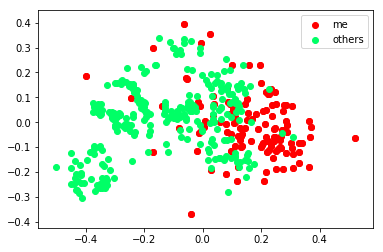

In [13]:
all_embeddings = np.concatenate((embed_me, embed_others), axis=0)
pca = PCA(n_components=2)

pca.fit(all_embeddings)

xy_me = pca.transform(embed_me)
xy_others = pca.transform(embed_others)

ax = plt.figure()

sc1 = plt.scatter(xy_me[:,0], xy_me[:,1], color=(1,0,0))
sc2 = plt.scatter(xy_others[:,0], xy_others[:,1], color=(0,1,0.4))

plt.legend([sc1,sc2],["me","others"], loc="upper right")
plt.savefig('embed_dist.jpg')

In [ ]:
cap = cv2.VideoCapture('D:/mip2019/data/videos/video1.mp4')
count = 0

while(True):
    ret, frame = cap.read()
    if ret == False:
        break
    else:
        conse = frame.copy()
        faces_others, bounding_boxes_others = crop_faces(frame, pnet, rnet, onet)
        for i in range(len(faces_others)):
            img = faces_others[i]
            result = sess.run(embeddings, feed_dict={single_image:img})
            result = result[0]
            distance_th = 0.18
            j = 0
            total = 0
            for j in range(len(embed_me)):
                distance = calc_distance(embed_me[j], result)
                total += distance
            avg_distance = total / len(embed_me)
            box = bounding_boxes_others[i]
            box = np.int32(box)
            p1 = (box[0], box[1])
            p2 = (box[2], box[3])
            if(avg_distance < distance_th):
                cv2.rectangle(conse, p1, p2, color=(0, 255, 0))
            else:
                cv2.rectangle(conse, p1, p2, color=(0, 0, 255))
        cv2.imwrite("D:/mip2019/data/conse/conse%d.jpg" % count, conse)
        count += 1
cap.release()

In [58]:
import cv2
import numpy as np
import glob
import sys
sys.path.append('D:/mip2019/data/conse')
img_array = []
for filename in glob.glob('D:/mip2019/data/conse/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('conse_face.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
# 실습에 저장됨